# Шаг 1. Импорт данных для работы

In [1]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import yaml
from bs4 import BeautifulSoup # Превращалка html в текст.

%matplotlib inline

df_sample = pd.read_csv('sampleSubmission.csv', sep = ',')
df_train = pd.read_csv('train.csv', sep = '\t')
df_test = pd.read_csv('test.csv', sep = '\t')
print('df_train ',df_train.shape)
print('df_test ',df_test.shape)

df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_test.append(df_train).reset_index(drop=True)
print('df ',df.shape)

# Переводим текстовы данные из test в словарь 'Название должности' + 'Описание'   
df_name = df[['name']].to_dict()['name']
df_desc = df[['description']].to_dict()['description']

df_namedesc = {}
for key in list(df_desc.keys()):
    df_namedesc['train'+str(key)] = df_name[key] + ' ' + df_desc[key]
print('df_namedesc ',len(df_namedesc))

del df_desc
del df_name 
   
# del df_sample
# del df_train
# del df_test

df_train  (200000, 4)
df_test  (170179, 3)
df  (370179, 5)
df_namedesc  370179
Wall time: 16.9 s


# Шаг 2. Подготовка текста: очистка от тегов, оставляем только нужные слова и т.п.

In [2]:
df_namedesc_re = {}
for line in df_namedesc.keys():
    df_namedesc_re[line] = ' '.join(
        re.findall(
            "[А-ЯЁа-яё]+[\:|\,|\.]*", df_namedesc[line]
        )
    )
print('df_namedesc_re ',len(df_namedesc_re))

del df_namedesc

df_namedesc_re  370179


# Шаг 3. Перевод текста в вектор для машинного обучения

In [3]:
%%time

from IPython.display import display, Math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer #импорт декодеров текста в вектор

# раскладываем каждый текст на вектор из 'max_features' слов/столбцов
coder = CountVectorizer(encoding='utf-8',ngram_range=(1, 2), analyzer='word',max_features=256)

Wall time: 455 ms


In [4]:
%%time

df_x = coder.fit_transform(df_namedesc_re.values())

df_preproc = pd.DataFrame(df_x.toarray())
df_preproc['sample'] = df['sample']
df_preproc['target'] = df['target']

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)
del df_preproc

df_y_train = list(df_train_preproc['target'])
df_x_train = df_train_preproc.drop(['target'], axis = 1)
df_y_test = list(df_test_preproc['target']) # здесь неизвестные значения Nan - которые нужно найти
df_x_test = df_test_preproc.drop(['target'], axis = 1) # здесь входные параметры
del df_train_preproc
del df_test_preproc

print('df_x_train ',df_x_train.shape)
print('df_y_train ',len(df_y_train))
print('df_x_test ',df_x_test.shape,'\n')

df_x_train  (200000, 256)
df_y_train  200000
df_x_test  (170179, 256) 

Wall time: 2min 48s


In [5]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.33, random_state=42)
print('X_train, y_train ',X_train.shape,'X_test, y ',X_test.shape)

C:\Users\drsadykov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


X_train, y_train  (134000, 256) X_test, y  (66000, 256)


# Шаг 4. Модели машинного обучения

In [6]:

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.cross_validation import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# model0 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('knn', KNeighborsClassifier(n_neighbors=5))
# ])

# model0.fit(X_train, y_train)

# predict = model0.predict(X_test)                      # делаем предсказание
# print('#'*10,'>>> Pipeline KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross0 = cross_val_score(model0,df_x_train,df_y_train,scoring='roc_auc', cv=10)

# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel0. Pipeline KNeighborsClassifier\t\t\t\t{:.4f}'
#       .format( (sum(cross0) / float(len(cross0))) ) )

In [12]:
dict_model = {}

# model1 = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2, metric='euclidean')
# model1.fit(X_train, y_train)

# predict = model1.predict(X_test)                      # делаем предсказание
# dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
# print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)

# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel1. KNeighborsClassifier\t\t\t\t{:.4f}'
#       .format( (sum(cross1) / float(len(cross1))) ) )

In [8]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# from ipywidgets import interact, IntSlider
# import subprocess

# try:
#     from sklearn.model_selection import validation_curve
# except ImportError:
#     from sklearn.learning_curve import validation_curve

# try:
#     from sklearn.model_selection import StratifiedKFold
# except ImportError:
#     from sklearn.cross_validation import StratifiedKFold

# # ---------------------------------------------------------------------
# # ищем максимальную точность на графике max_depth

# model2 = DecisionTreeClassifier(random_state=123)
# model2.fit(X_train, y_train)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)
# train_scores, valid_scores = validation_curve(model2, X_train, y_train, 
#                                               'max_depth', range(1, 10),
#                                               cv=cv, scoring='roc_auc')
# train_score_mean = train_scores.mean(axis=1)
# train_score_std = train_scores.std(axis=1)
# valid_scores_mean = valid_scores.mean(axis=1)
# valid_scores_std = valid_scores.std(axis=1)

# plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
#                  interpolate=True, alpha=0.5,)
# plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
#                  interpolate=True, alpha=0.5)

# plt.plot(range(1,10), train_score_mean, c='b', lw=2) #синяя линия обучающая выборка
# plt.plot(range(1,10), valid_scores_mean, c='r', lw=2) #красная линяя - валидационная выборка

# plt.xlabel('max depth')
# plt.ylabel('ROC AUC')

# # ---------------------------------------------------------------------

In [9]:
# depth=6 #видно из графика

# model2 = DecisionTreeClassifier(max_depth = depth, random_state=123)
# model2.fit(X_train, y_train)

# predict = model2.predict(X_test)                      # делаем предсказание
# dict_model ['DecisionTreeClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
# print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)

# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel2. DecisionTreeClassifier\t\t\t\t{:.4f}'
#       .format( (sum(cross2) / float(len(cross2))) ) )

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.92      0.94      0.93     34984
        1.0       0.93      0.90      0.92     31016

avg / total       0.92      0.92      0.92     66000
 

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.92      0.94      0.93     34984
        1.0       0.93      0.91      0.92     31016

avg / total       0.92      0.92      0.92     66000
 

Wall time: 53.7 s


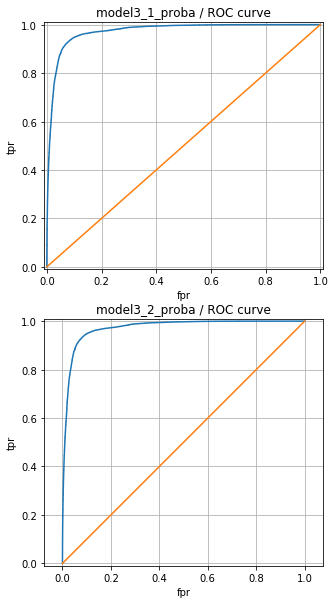

In [13]:
%%time
from sklearn.linear_model import LogisticRegression

model3_1 = LogisticRegression()                     # инициализируем модель
model3_1.fit(X_train, y_train)                      # обучаем модель
predict = model3_1.predict(X_test)                      # делаем предсказание
# dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross3_1 = cross_val_score(model3_1,df_x_train,df_y_train,scoring='roc_auc', cv=10)


# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel3_1. LogisticRegression\t\t\t\t{:.4f}'
#       .format( (sum(cross3_1) / float(len(cross3_1))) ) )



model3_2 = LogisticRegression(class_weight='balanced')                     # инициализируем модель
model3_2.fit(X_train, y_train)                      # обучаем модель
predict = model3_2.predict(X_test)                      # делаем предсказание
# dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross3_2 = cross_val_score(model3_2,df_x_train,df_y_train,scoring='roc_auc', cv=10)

# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel3_2. LogisticRegression (class_weight=balanced) \t{:.4f}'
#       .format( (sum(cross3_2) / float(len(cross3_2))) ) )




plt.figure(figsize=(5, 10))

#subplot 1
plt.subplot(211)
predict_proba1 = model3_1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('model3_1_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(212)
predict_proba2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('model3_2_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [ ]:
# from scipy.stats import randint as randint
# from scipy.stats import uniform

# try:
#     from sklearn.model_selection import GridSearchCV
#     from sklearn.model_selection import RandomizedSearchCV
#     from sklearn.model_selection import StratifiedKFold
# except ImportError:
#     from sklearn.cross_validation import GridSearchCV
#     from sklearn.cross_validation import RandomizedSearchCV
#     from sklearn.cross_validation import StratifiedKFold

# param_grid = {
#     'criterion': ['gini', 'entropy'], #критерии
#     'max_depth': randint(2, 8), #максимальная глубина от 2 до 8
#     'min_samples_leaf': randint(5, 10), #минимальное количество объектов в вершие дерева, достаточное чтоб дробить дерево на части
#     'class_weight': [None, 'balanced']} #объекты классов, которые недопредставлены в выборке, будет взвешивать и балансировать

# # Некоторые параметры мы задали не простым перечислением значений, а с помощью распределений.

# # Будем делать 200 запусков поиска
# cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# model4 = DecisionTreeClassifier(random_state=123)
# random_search = RandomizedSearchCV(model4, param_distributions=param_grid, n_iter=200, n_jobs=-1,
#                                    cv=cv, scoring='roc_auc', random_state=123) #200 переборов, n_jobs=-1 дает параллельное вычисление
# # А дальше, просто .fit()
# random_search.fit(X_train, y_train)
# model4best = random_search.best_estimator_

# predict = model4best.predict(X_test)                      # делаем предсказание
# dict_model ['DecisionTreeClassifier random_search']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
# print('#'*10,'>>> DecisionTreeClassifier random_search <<<','#'*10,'\n',classification_report(y, predict),'\n')

# cross4 = cross_val_score(model4best,df_x_train,df_y_train,scoring='roc_auc', cv=10)

# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel4. DecisionTreeClassifier random_search \t{:.4f}'
#       .format( (sum(cross4) / float(len(cross4))) ) )

In [ ]:
# # Потроить roc-кривые всех можелей на одном графике
# # Вывести roc_auc каждой моделе
# # Подпишите оси и линии

# plt.figure(figsize=(15, 15))

# #subplot 1
# plt.subplot(221)
# predict_proba1 = model1.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1])
# plt.ylabel('tpr')
# plt.xlabel('fpr')
# plt.grid(True)
# plt.title('KNeighborsClassifier / ROC curve')
# plt.xlim((-0.01, 1.01))
# plt.ylim((-0.01, 1.01))

# #subplot 2
# plt.subplot(222)
# predict_proba2 = model2.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
# plt.plot(fpr, tpr);
# plt.plot([0, 1], [0, 1])
# plt.ylabel('tpr')
# plt.xlabel('fpr')
# plt.axis('equal')
# plt.grid(True)
# plt.title('DecisionTreeClassifier / ROC curve')
# plt.xlim((-0.01, 1.01))
# plt.ylim((-0.01, 1.01))

# #subplot 3
# plt.subplot(223)
# predict_proba3_2 = model3_2.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y, predict_proba3_2[:,1])
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1])
# plt.ylabel('tpr')
# plt.xlabel('fpr')
# plt.grid(True)
# plt.title('LogisticRegression (class_weight=balanced) / ROC curve')
# plt.xlim((-0.01, 1.01))
# plt.ylim((-0.01, 1.01))

# #subplot 4
# plt.subplot(224)
# predict_proba3 = model4best.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1])
# plt.ylabel('tpr')
# plt.xlabel('fpr')
# plt.grid(True)
# plt.title('DecisionTreeClassifier random_search/ ROC curve')
# plt.xlim((-0.01, 1.01))
# plt.ylim((-0.01, 1.01))
# plt.show()

In [ ]:
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel0. Pipeline KNeighborsClassifier\t\t\t{:.4f}'
#       .format( (sum(cross0) / float(len(cross0))) ) )
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel1. KNeighborsClassifier\t\t\t\t{:.4f}'
#       .format( (sum(cross1) / float(len(cross1))) ) )
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel2. DecisionTreeClassifier\t\t\t\t{:.4f}'
#       .format( (sum(cross2) / float(len(cross2))) ) )
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel3_1. LogisticRegression\t\t\t\t{:.4f}'
#       .format( (sum(cross3_1) / float(len(cross3_1))) ) )
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel3_2. LogisticRegression (class_weight=balanced) \t{:.4f}'
#       .format( (sum(cross3_2) / float(len(cross3_2))) ) )
# print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
#       '\nmodel4. DecisionTreeClassifier random_search \t\t{:.4f}'
#       .format( (sum(cross4) / float(len(cross4))) ) )


# Запись результатов по лучшей модели.

In [ ]:
predict = model3_2.predict(df_x_test)
df_predict = pd.DataFrame(list(df_test['id']))
df_predict.columns = ['id']
df_predict['target'] = pd.DataFrame(predict)
print(df_predict.head())

df_predict.to_csv('result_submission_hw04.csv', sep=',', encoding='utf-8',index=False)

# ДАЛЬШЕ НИЖЕ ИДЕТ МОЙ БРЕД!!!

In [63]:
df_sample = pd.read_csv('sampleSubmission.csv', sep = '\t')
df_sample.head()

,"id,target"
0,"200000,0"
1,"200001,0"
2,"200002,0"
3,"200003,0"
4,"200004,0"


In [ ]:
# words = [x[0] for x in sorted(coder.vocabulary_.items(), key=lambda x: x[1])]

In [96]:
df_sample.head()

,id,target
0,200000,0
1,200001,0
2,200002,0
3,200003,0
4,200004,0


,id,target
0,200000,1
1,200001,1
2,200002,1
3,200003,1
4,200004,0


# Посчитаем лишние слова

In [79]:
# %%time

# words = {}
# for line in list(df_dict_re.keys()):
#     for word in df_dict_re[line].split():
#         if words.get(word):
#             words[word] += 1
#         else:
#             words[word] = 1
# print(len(words))

# df_words = pd.DataFrame(list(words.items())).sort_values(by=1, ascending=False).reset_index(drop=True)
# df_words['len_0'] = df_words[0].map(lambda x: len(x) )
# df_block_words = df_words[df_words['len_0'] <4] # лишние слова - когда длина слов меньше или равно 3-х

CPU times: user 29.3 s, sys: 1.83 s, total: 31.1 s
Wall time: 32.1 s


# Метод 1: подсчет слов вручную в словарь и перевод в DataFrame

In [ ]:
# %%time

# # pstrong = re.compile('<p><strong>(.+?)</strong></p>', re.S)
# # p = re.compile('<p>.+?</p>', re.S)
# # ulli = re.compile("<ul>\ <li>(.+?)</li>\ </ul>", re.S)
# # ''.join(ulli.split(''.join(p.split(''.join(pstrong.split(df_dict[line]))))))

# df_dict_re = {}
# for line in df_dict.keys():
#     df_dict_re[line] = ' '.join(re.findall("[А-ЯЁа-яё]+[\:|\,|\.]*", df_dict[line]))
# print('df_dict_re ',len(df_dict_re))

In [51]:
# %%time

# word_to_number_for_each_texts = {}
# for text in df_dict_re.values():
#     word_to_number_for_each_texts[text] = {}
#     for word in text.split():
#         if word_to_number_for_each_texts[text].get(word):
#             word_to_number_for_each_texts[text][word] += 1
#         else:
#             word_to_number_for_each_texts[text][word] = 1
# len(word_to_number_for_each_texts)

# %%time

CPU times: user 25.6 s, sys: 2.17 s, total: 27.7 s
Wall time: 28.2 s


In [116]:
# %%time

# # df_dict_re_matrix = pd.DataFrame(list(word_to_number_for_each_texts.values())).fillna(0)
# # df_dict_re_matrix.head().T

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 26.9 µs


In [22]:
# %%time

# from IPython.display import display, Math

# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# import scipy.sparse as sp
# from nltk.text import TextCollection

# count_vect = CountVectorizer()
# temp_matrix = count_vect.fit_transform(df_dict_re.values()) # temp_matrix эта промежуточная матрица, понадобится в следующем кейсе,
#                                               # для вычисления tf-idf в данной матрице хранятся 
# matrix_counts = temp_matrix.toarray()

# words = [x[0] for x in sorted(count_vect.vocabulary_.items(), key=lambda x: x[1])] # список слов, 
#                                                                                    # чтобы сделать красивую шапку
# print(len(words))
# # pd.DataFrame(matrix_counts, columns=words)  # при создании DataFrame передадим подготовленный список слов

CPU times: user 851 ms, sys: 1.96 s, total: 2.81 s
Wall time: 3.77 s


# Метод 2: через вектора слов 

Для новостной заметки можно составить ее словарь, а также посчитать частоты всех слов. В итоге мы получим представление текста в виде вектора. В этом векторе координаты будут называться по соответствующим словам, а смещение по данной координате будет показывать частота. <br>
При составлении словаря будем учитывать только значимые слова - существительные, прилагательные и глаголы. Помимо этого предусмотрим возможность учитывать часть речи слова, прибавляя ее у начальной форме.<br>
Для разделения текста на слова используем простейший алгоритм: слово - это последовательность букв русского алфавита среди которых может попадаться дефис. 

In [8]:
# import pymorphy2 # Морфологический анализатор.
# from collections import Counter # Не считать же частоты самим.
# import math # Корень квадратный.

# morph = pymorphy2.MorphAnalyzer() # Создает объект морфоанализатора и загружет словарь.

# posConv={'ADJF':'_ADJ','NOUN':'_NOUN','VERB':'_VERB'}
# meaningfullPoSes=['ADJF', 'NOUN', 'VERB']
# def getArticleDictionary(text, needPos=None):
#     words=[a[0] for a in re.findall("([А-ЯЁа-яё]+(-[А-ЯЁа-яё]+)*)", text)]
#     reswords=[]
#     for w in words:
#         wordform=morph.parse(w)[0]
#         if wordform.tag.POS in meaningfullPoSes:
#             if needPos!=None:
#                 reswords.append(wordform.normal_form+posConv[wordform.tag.POS])
#             else:
#                 reswords.append(wordform.normal_form)
#     return Counter(reswords)

# # print(dict(getArticleDictionary(df_dict_re[1], True)))

ModuleNotFoundError: No module named 'pymorphy2'

In [104]:
# %%time

# df_dict_vector = {}
# for line in df_dict.keys():
#     df_dict_vector[line] = (dict(getArticleDictionary(df_dict[line], True)))
# print('df_dict_vector ',len(df_dict_vector))

df_dict_vector  370179
CPU times: user 3h 54min 23s, sys: 33.2 s, total: 3h 54min 56s
Wall time: 3h 56min 8s


In [117]:
%%time

# with open('df_dict.yml', 'w') as f:
#     yaml.dump(df_dict_vector, f, default_flow_style=False)
    
# with open('df_dict.yml', 'r') as f:
#     df_dict_vector = load(f)

CPU times: user 14 µs, sys: 23 µs, total: 37 µs
Wall time: 43.2 µs


In [5]:
# import yaml

# # df_name_vector = {}
# # for line in df_name.keys():
# #     df_name_vector[line] = (dict(getArticleDictionary(df_name[line], True)))
# # print('df_name_vector ',len(df_name_vector))

# # with open('df_name.yml', 'w') as f:
# #     yaml.dump(df_name_vector, f, default_flow_style=False)

# with open('df_name.yml', 'r') as f:
#     df_name = yaml.load(f)

In [14]:
# df_name_list = []
# for line in list(df_name.keys()):
#     df_name_list.append(' '.join(list(df_name[line].keys())))
# df_name_list    

['дизайнер-консультант_NOUN мебель_NOUN',
 'продавец-консультант_NOUN пушкин_NOUN',
 'менеджер_NOUN продажа_NOUN',
 'волна_NOUN магазин_NOUN метр_NOUN новокосино_NOUN одежда_NOUN продавец-консультант_NOUN',
 'охрана_NOUN специалист_NOUN труд_NOUN',
 'аэс_NOUN качество_NOUN обеспечение_NOUN рубеж_NOUN сооружение_NOUN эксперт_NOUN',
 'арзамас_NOUN представитель_NOUN торговый_ADJ',
 'генеральный_ADJ директор_NOUN заместитель_NOUN производство_NOUN',
 '',
 'дизайнер-конструктор_NOUN',
 'телемаркетолог_NOUN',
 'агент_NOUN продажа_NOUN',
 'ассистент_NOUN маркетинг_NOUN отдел_NOUN руководитель_NOUN',
 'продавец-консультант_NOUN',
 'менеджер_NOUN направление_NOUN продажа_NOUN туристический_ADJ',
 'продавец-консультант_NOUN',
 'валов_NOUN коленчатый_ADJ шлифовщик_NOUN',
 'ведущий_ADJ менеджер_NOUN направление_NOUN продажа_NOUN руководитель_NOUN',
 'ветеринарный_ADJ врач_NOUN консультант_NOUN',
 'представитель_NOUN торговый_ADJ',
 'продавец-консультант_NOUN',
 'продавец-консультант_NOUN',
 'быто

In [15]:
# %%time

# from IPython.display import display, Math

# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# import scipy.sparse as sp
# from nltk.text import TextCollection

# count_vect = CountVectorizer()
# temp_matrix = count_vect.fit_transform(df_name_list) # temp_matrix эта промежуточная матрица, понадобится в следующем кейсе,
#                                               # для вычисления tf-idf в данной матрице хранятся 
# matrix_counts = temp_matrix.toarray()



Wall time: 7.58 s


In [33]:
# words = [x[0] for x in sorted(count_vect.vocabulary_.items(), key=lambda x: x[1])] # список слов, 
#                                                                                    # чтобы сделать красивую шапку
# print(len(words))
# df_name_list_df = pd.DataFrame(matrix_counts, columns=words)  # при создании DataFrame передадим подготовленный список слов
# print(df_name_list_df.info())

15053
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370179 entries, 0 to 370178
Columns: 15053 entries, аазс_noun to ёмкость_noun
dtypes: int64(15053)
memory usage: 41.5 GB
None


# Метод 4. TfidfVectorizer

In [20]:
# from sklearn.feature_extraction.text import CountVectorizer

# counter=CountVectorizer()
# # Просим посчитать частоты слов.
# res=counter.fit_transform([df_dict[0]])

In [26]:
# # При помощи ngram_range=(1,2) говорим, что хотим извлекать слова и пары слов.
# # token_pattern показывает регулярное выражение, которому должны соответствовать слова.
# counter12=CountVectorizer(ngram_range=(1,2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')
# # Проводим анализ, получаем список найденных n-грамм.
# analyze = counter12.build_analyzer()
# print(analyze(df_dict[0]))
# # Считаем частоты, видим, что слова не приводились к начальной форме.
# res=counter12.fit_transform([df_dict[0]])
# print(counter12.vocabulary_.get('уверенный'))
# # print(counter12.vocabulary_.get('мама'))

['обязанности', 'работа', 'с', 'клиентом', 'в', 'салоне', 'выезд', 'на', 'замер', 'создание', 'дизайн-проекта', 'расчеты', 'ведение', 'документации', 'заключение', 'договоров', 'требования', 'опыт', 'работы', 'желателен', 'уверенный', 'пользователь', 'пк', 'грамотная', 'речь', 'желание', 'учиться', 'и', 'развиваться', 'условия', 'трудоустройство', 'по', 'тк', 'обучение', 'стажировка', 'оклад', 'от', 'личных', 'продаж', 'удобный', 'график', 'обязанности работа', 'работа с', 'с клиентом', 'клиентом в', 'в салоне', 'салоне выезд', 'выезд на', 'на замер', 'замер создание', 'создание дизайн-проекта', 'дизайн-проекта расчеты', 'расчеты ведение', 'ведение документации', 'документации заключение', 'заключение договоров', 'договоров требования', 'требования опыт', 'опыт работы', 'работы желателен', 'желателен уверенный', 'уверенный пользователь', 'пользователь пк', 'пк грамотная', 'грамотная речь', 'речь желание', 'желание учиться', 'учиться и', 'и развиваться', 'развиваться условия', 'условия 

In [28]:
# import pymorphy2 # Морфологический анализатор.
# from collections import Counter # Не считать же частоты самим.
# import math # Корень квадратный.

# morph = pymorphy2.MorphAnalyzer() # Создает объект морфоанализатора и загружет словарь.

# def getMeaningfullWords(text):
#     words=[]
#     tokens=re.findall('[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+', text)
#     for t in tokens:
#         pv=morph.parse(t)
#         for p in pv:
#             if p.tag.POS in ['ADJF', 'NOUN', 'VERB']:
#                 words.append(p.normal_form)
#                 break
#     return words

# c=[' '.join(getMeaningfullWords(df_dict[0]))]
# c2=[' '.join([morph.parse(r)[0].normal_form for r in re.findall('[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+', df_dict[0])])]

# lemmaCounter=CountVectorizer(ngram_range=(1,2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')

# analyze = lemmaCounter.build_analyzer()
# res1=analyze(c[0])
# res2=lemmaCounter.fit_transform(c)
# print({w:res2[0][0,lemmaCounter.vocabulary_[w]] for w in lemmaCounter.vocabulary_ if res2[0][0,lemmaCounter.vocabulary_[w]]>1})
# print("---")
# res1=analyze(c2[0])
# res2=lemmaCounter.fit_transform(c2)
# print({w:res2[0][0,lemmaCounter.vocabulary_[w]] for w in lemmaCounter.vocabulary_ if res2[0][0,lemmaCounter.vocabulary_[w]]>1})


{'работа': 2}
---
{'работа': 2}


In [12]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np

# tfCounter=TfidfVectorizer(ngram_range=(1,2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')

# analyze = tfCounter.build_analyzer()
# res=tfCounter.fit_transform([df_dict[0]])
# print(df_dict[0])

<p><strong>Обязанности:</strong></p> <ul> <li>Работа с клиентом в салоне,выезд на замер ,создание дизайн-проекта,расчеты,ведение документации,заключение договоров</li> </ul> <p> </p> <p><strong>Требования:</strong></p> <ul> <li>Опыт работы желателен,уверенный пользователь ПК,грамотная речь,желание учиться и развиваться</li> </ul> <p> </p> <p><strong>Условия:</strong></p> <ul> <li>Трудоустройство по ТК, обучение+стажировка,оклад+% от личных продаж,удобный график</li> </ul>


In [17]:
# id_article=6
# res2=analyze(df_dict[1])
# tfs=list(set(res[0, tfCounter.vocabulary_.get(k)] for k in res2 if k in tfCounter.vocabulary_.keys()))

In [31]:
# print({w:res[0, tfCounter.vocabulary_[w]] for w in res2 if w in tfCounter.vocabulary_.keys() and res[id_article][0, tfCounter.vocabulary_[w]] in tfs2})